### JUST DQN

In [ ]:
!pip install swig
!pip install gymnasium
!pip install gym[box2d]
import gymnasium as gym
env = gym.make("BipedalWalker-v3")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.5 MB/s eta 0:00:00
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376418 sha256=3fd7e0b2a2862b5afcd3e660fd96d9b57d082989749a5a12523085eebfc5f6c7
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.1
    Uninstalling pygame-2.6.1:
      Successfully uninstalled pygame-2.6.1


<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
import gymnasium as gym
from gym.spaces import Discrete
import numpy as np
import collections
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.98
buffer_limit = 50000
batch_size = 64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Custom discrete action wrapper
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env, n_actions_per_dim=5):
        super().__init__(env)
        self.n_actions_per_dim = n_actions_per_dim
        self.action_space = Discrete(n_actions_per_dim ** env.action_space.shape[0])
        self._create_action_map()

    def _create_action_map(self):
        """Creates a mapping from discrete actions to continuous actions."""
        n_dims = self.env.action_space.shape[0]
        action_ranges = [np.linspace(-1, 1, self.n_actions_per_dim) for _ in range(n_dims)]
        self.action_map = np.array(np.meshgrid(*action_ranges)).T.reshape(-1, n_dims)

    def action(self, act):
        return self.action_map[act]

In [ ]:
# # Replay Buffer
# class ReplayBuffer:
#     def __init__(self):
#         self.buffer = collections.deque(maxlen=buffer_limit)

#     def put(self, transition):
#         self.buffer.append(transition)

#     def sample(self, n):
#         mini_batch = random.sample(self.buffer, n)
#         s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

#         for transition in mini_batch:
#             s, a, r, s_prime, done_mask = transition
#             s_lst.append(s)
#             a_lst.append([a])
#             r_lst.append([r])
#             s_prime_lst.append(s_prime)
#             done_mask_lst.append([done_mask])

#         return (torch.tensor(s_lst, dtype=torch.float),
#                 torch.tensor(a_lst),
#                 torch.tensor(r_lst),
#                 torch.tensor(s_prime_lst, dtype=torch.float),
#                 torch.tensor(done_mask_lst))

#     def size(self):
#         return len(self.buffer)

# ReplayBuffer 업데이트

class ReplayBuffer:
    def __init__(self, buffer_limit, action_space, device):
        self.buffer = collections.deque(maxlen=buffer_limit)
        self.action_space = action_space
        self.device = device

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        state_lst, reward_lst, next_state_lst, done_mask_lst = [], [], [], []
        actions_lst = [[] for _ in range(self.action_space)]

        for transition in mini_batch:
            state, actions, reward, next_state, done_mask = transition
            state_lst.append(state)
            for i in range(self.action_space):
                actions_lst[i].append(actions[i])
            reward_lst.append([reward])
            next_state_lst.append(next_state)
            done_mask_lst.append([done_mask])

        # Tensor 변환
        actions_lst = [torch.tensor(x, dtype=torch.long).to(self.device) for x in actions_lst]
        return (
            torch.tensor(state_lst, dtype=torch.float).to(self.device),
            actions_lst,
            torch.tensor(reward_lst, dtype=torch.float).to(self.device),
            torch.tensor(next_state_lst, dtype=torch.float).to(self.device),
            torch.tensor(done_mask_lst, dtype=torch.float).to(self.device),
        )

    def size(self):
        return len(self.buffer)

In [ ]:
# class Qnet(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(Qnet, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128, output_dim)  # output_dim은 변환된 행동 공간 크기

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

#     def sample_action(self, obs, epsilon):
#         obs = obs.unsqueeze(0)  # Batch 차원 추가
#         out = self.forward(obs)
#         coin = random.random()
#         if coin < epsilon:
#             return random.randint(0, out.size(-1) - 1)  # 올바른 출력 차원을 참조
#         else:
#             return out.argmax().item()

# QNetwork 업데이트
class QNetwork(nn.Module):
    def __init__(self, state_space: int, action_space: int, action_scale: int):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_space, 128)
        self.fc2 = nn.Linear(128, 64)

        # 각 행동 차원에 대한 출력 레이어
        self.actions = nn.ModuleList(
            [nn.Linear(64, action_scale) for _ in range(action_space)]
        )
        self.value = nn.Linear(64, 1)  # 상태 가치 계산

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # 각 행동 차원의 Q값 계산
        action_outputs = [layer(x) for layer in self.actions]
        value = self.value(x)

        # 각 행동에 대해 상태 가치 더하기
        q_values = [
            action_output - action_output.max(-1, keepdim=True)[0] + value
            for action_output in action_outputs
        ]
        return q_values

In [ ]:
# # Training function
# def train(q, q_target, memory, optimizer):
#     for _ in range(10):
#         s, a, r, s_prime, done_mask = memory.sample(batch_size)

#         q_out = q(s)
#         q_a = q_out.gather(1, a)
#         max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
#         target = r + gamma * max_q_prime * done_mask
#         loss = F.smooth_l1_loss(q_a, target)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

# 학습 루프 수정
def train(agent, memory, batch_size, gamma, optimizer, use_tensorboard, writer, episode):
    states, actions, rewards, next_states, dones = memory.sample(batch_size)

    q_values = agent(states)  # Q값 계산
    next_q_values = agent(next_states)

    loss = 0
    for i in range(len(q_values)):  # 각 행동 차원별로 학습
        q_value = q_values[i].gather(1, actions[i].unsqueeze(-1))
        max_next_q_value = next_q_values[i].max(1)[0].unsqueeze(1)
        target = rewards + gamma * max_next_q_value * dones
        loss += F.smooth_l1_loss(q_value, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if use_tensorboard:
        writer.add_scalar("Loss", loss.item(), episode)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Input dimension: 24, Output dimension: 625


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


New best score: -109.41. Model saved.
n_episode: 10, avg_score: -122.27, buffer: 997, epsilon: 8.0%


<ipython-input-5-9476fa3537b4>:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return (torch.tensor(s_lst, dtype=torch.float),


n_episode: 20, avg_score: -118.54, buffer: 2835, epsilon: 7.9%
New best score: -98.86. Model saved.
n_episode: 30, avg_score: -118.10, buffer: 10550, epsilon: 7.8%
n_episode: 40, avg_score: -107.65, buffer: 14386, epsilon: 7.8%
New best score: -78.16. Model saved.
n_episode: 50, avg_score: -98.13, buffer: 22941, epsilon: 7.8%
n_episode: 60, avg_score: -103.60, buffer: 29762, epsilon: 7.7%
n_episode: 70, avg_score: -107.24, buffer: 35204, epsilon: 7.6%
n_episode: 80, avg_score: -108.04, buffer: 38019, epsilon: 7.6%
n_episode: 90, avg_score: -112.57, buffer: 42767, epsilon: 7.5%
n_episode: 100, avg_score: -117.83, buffer: 47330, epsilon: 7.5%
New best score: -75.13. Model saved.
n_episode: 110, avg_score: -119.77, buffer: 50000, epsilon: 7.4%
n_episode: 120, avg_score: -98.67, buffer: 50000, epsilon: 7.4%
n_episode: 130, avg_score: -101.21, buffer: 50000, epsilon: 7.3%
n_episode: 140, avg_score: -123.45, buffer: 50000, epsilon: 7.3%
n_episode: 150, avg_score: -112.37, buffer: 50000, epsi

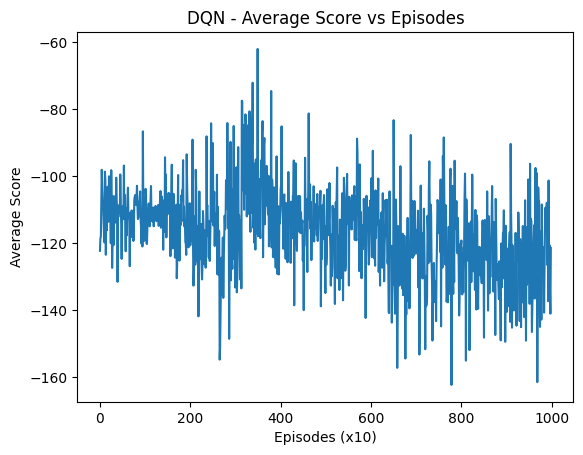

In [ ]:
# '''
# DQN 알고리즘을 사용하여 연속 액션 공간 환경(바이페달 워커 v3와 같은)을 해결하는 것은 DQN 알고리즘이 쌍(상태, 액션)의 반복적 최적화 프로세스에 의존하기 때문에 나쁜 생각입니다. TD3, SAC 또는 PPO와 같은 다른 알고리즘으로 변경하는 것이 좋습니다.
# '''

# def main():
#     env = gym.make("BipedalWalker-v3")
#     env = DiscreteActionWrapper(env, n_actions_per_dim=5)  # 이산 행동 공간으로 변환
#     input_dim = env.observation_space.shape[0]
#     output_dim = env.action_space.n  # 변환된 이산 행동 공간 크기

#     print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

#     # Qnet 초기화
#     q = Qnet(input_dim, output_dim)
#     q_target = Qnet(input_dim, output_dim)
#     q_target.load_state_dict(q.state_dict())

#     memory = ReplayBuffer()
#     optimizer = optim.Adam(q.parameters(), lr=learning_rate)

#     best_score = -float('inf')
#     print_interval = 10
#     score = 0.0
#     avg_scores = []

#     for n_epi in range(10000):
#         epsilon = max(0.01, 0.08 - 0.01 * (n_epi / 200))

#         reset_result = env.reset()
#         if isinstance(reset_result, tuple):
#             s, info = reset_result
#         else:
#             s = reset_result
#             info = {}

#         done = False

#         while not done:
#             a = q.sample_action(torch.from_numpy(s).float(), epsilon)
#             step_result = env.step(a)

#             if len(step_result) == 5:
#                 s_prime, r, done, truncated, info = step_result
#                 done_mask = 0.0 if (done or truncated) else 1.0
#             else:
#                 s_prime, r, done, info = step_result
#                 done_mask = 0.0 if done else 1.0

#             memory.put((s, a, r, s_prime, done_mask))
#             s = s_prime

#             score += r
#             if done:
#                 break

#         if memory.size() > 2000:
#             train(q, q_target, memory, optimizer)

#         if score >= best_score:
#             best_score = score
#             torch.save(q.state_dict(), f"dqn_bipedal{n_epi}_.pth")
#             print(f"New best score: {best_score:.2f}. Model saved.")

#         if n_epi % print_interval == 0 and n_epi != 0:
#             avg_score = score / print_interval
#             avg_scores.append(avg_score)
#             q_target.load_state_dict(q.state_dict())
#             print(f"n_episode: {n_epi}, avg_score: {avg_score:.2f}, buffer: {memory.size()}, epsilon: {epsilon * 100:.1f}%")
#             score = 0.0

#     env.close()
#     plt.plot(avg_scores)
#     plt.xlabel('Episodes (x10)')
#     plt.ylabel('Average Score')
#     plt.title('DQN - Average Score vs Episodes')
#     plt.show()



# if __name__ == "__main__":
#     main()

# Main 코드 수정
env = gym.make("BipedalWalker-v3")
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]
action_scale = args.action_scale

agent = QNetwork(state_space, action_space, action_scale).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.lr_rate)
memory = ReplayBuffer(buffer_limit=100000, action_space=action_space, device=device)

real_action = np.linspace(-1., 1., action_scale)

for n_epi in range(args.epochs):
    state = env.reset()
    done = False
    score = 0.0

    while not done:
        epsilon = max(0.01, 0.9 - 0.01 * (n_epi / 10))
        if random.random() < epsilon:
            action = [random.randint(0, action_scale - 1) for _ in range(action_space)]
        else:
            action_probs = agent(torch.tensor(state, dtype=torch.float32).to(device))
            action = [int(prob.max(1)[1]) for prob in action_probs]

        next_state, reward, done, _ = env.step([real_action[a] for a in action])
        memory.put((state, action, reward, next_state, 0.0 if done else 1.0))
        state = next_state
        score += reward

        if memory.size() > batch_size:
            train(agent, memory, batch_size, gamma, optimizer, use_tensorboard, writer, n_epi)

    if n_epi % args.save_interval == 0:
        torch.save(agent.state_dict(), f"./model_weights/agent_{n_epi}.pth")
    if n_epi % args.print_interval == 0:
        print(f"Episode {n_epi}, Score: {score:.2f}")


In [ ]:
import gymnasium as gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pygame

os.environ['SDL_VIDEODRIVER']='dummy'
pygame.display.set_mode((640,480))


<Surface(640x480x32 SW)>

In [ ]:
env = gym.make('BipedalWalker-v3', max_episode_steps=1000, render_mode='human')
env = DiscreteActionWrapper(env, n_actions_per_dim=5)  # 이산 행동 공간으로 변환
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n  # 변환된 이산 행동 공간 크기
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

q_target = Qnet(input_dim, output_dim)
q_target.load_state_dict(torch.load("./dqn_bipedal461_.pth"))
print("Model loaded from dqn_cartpole.pth")

reset_result = env.reset()

if isinstance(reset_result, tuple):
  s, info = reset_result
else:
  s = reset_result
  info = {}

done = False
total_reward = 0

while not done:
    a = q_target.sample_action(torch.from_numpy(s).float(), epsilon=0.0)
    s, r, done, truncated, info = env.step(a)
    total_reward += r
    if done or truncated:
        break

print("Total reward achieved: {:.1f}".format(total_reward))
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-30-9aa806205a67>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-mode

Input dimension: 24, Output dimension: 625
Model loaded from dqn_cartpole.pth
Total reward achieved: -83.9


In [ ]:
# Gym 환경 생성 시 render_mode를 설정
env = gym.make('BipedalWalker-v3', max_episode_steps=1000, render_mode='rgb_array')
env = DiscreteActionWrapper(env, n_actions_per_dim=5)  # 이산 행동 공간으로 변환
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n  # 변환된 이산 행동 공간 크기
print(f"Input dimension: {input_dim}, Output dimension: {output_dim}")

q_target = Qnet(input_dim, output_dim)
q_target.load_state_dict(torch.load("./dqn_bipedal461_.pth"))
print("Model loaded from dqn_bipedal461_.pth")

reset_result = env.reset(seed=32)
done = False
total_reward = 0

output_folder = "./videos"  # 저장할 폴더 경로
os.makedirs(output_folder, exist_ok=True)  # 폴더가 없으면 생성
video_filename = os.path.join(output_folder, "dqn_bipedal.avi")  # 파일 경로 설정

# 프레임 크기를 얻기 위해 초기 프레임 가져오기
frame = env.render()
frame_width, frame_height = frame.shape[1], frame.shape[0]

fourcc = cv2.VideoWriter_fourcc(*'XVID')  # 코덱 설정 (XVID, MP4V 등)
fps = 30  # 초당 프레임 수
video_writer = cv2.VideoWriter(video_filename, fourcc, fps, (frame_width, frame_height))

# 에피소드 실행
while not done:
    a = q_target.sample_action(torch.from_numpy(s).float(), epsilon=0.0)
    s, r, done, truncated, info = env.step(a)
    total_reward += r

    # 현재 프레임을 저장
    frame = env.render()  # 초기화 시 render_mode='rgb_array'로 설정했기 때문에 렌더링 가능
    video_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # OpenCV는 BGR 포맷 사용
    video_writer.write(video_frame)

    if done or truncated:
        break

# 리소스 정리
env.close()
video_writer.release()
print("Total reward achieved: {:.1f}".format(total_reward))
print(f"Video saved as {video_filename}")


Input dimension: 24, Output dimension: 625
Model loaded from dqn_bipedal461_.pth


<ipython-input-34-2a2e0ddcabf0>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_target.load_state_dict(torch.load("./dqn_bipedal461_.pth"))


Total reward achieved: -83.8
Video saved as ./videos/dqn_bipedal.avi


In [ ]:






# Main 코드 수정
env = gym.make("BipedalWalker-v3")
state_space = env.observation_space.shape[0]
action_space = env.action_space.shape[0]
action_scale = args.action_scale

agent = QNetwork(state_space, action_space, action_scale).to(device)
optimizer = optim.Adam(agent.parameters(), lr=args.lr_rate)
memory = ReplayBuffer(buffer_limit=100000, action_space=action_space, device=device)

real_action = np.linspace(-1., 1., action_scale)

for n_epi in range(args.epochs):
    state = env.reset()
    done = False
    score = 0.0

    while not done:
        epsilon = max(0.01, 0.9 - 0.01 * (n_epi / 10))
        if random.random() < epsilon:
            action = [random.randint(0, action_scale - 1) for _ in range(action_space)]
        else:
            action_probs = agent(torch.tensor(state, dtype=torch.float32).to(device))
            action = [int(prob.max(1)[1]) for prob in action_probs]

        next_state, reward, done, _ = env.step([real_action[a] for a in action])
        memory.put((state, action, reward, next_state, 0.0 if done else 1.0))
        state = next_state
        score += reward

        if memory.size() > batch_size:
            train(agent, memory, batch_size, gamma, optimizer, use_tensorboard, writer, n_epi)

    if n_epi % args.save_interval == 0:
        torch.save(agent.state_dict(), f"./model_weights/agent_{n_epi}.pth")
    if n_epi % args.print_interval == 0:
        print(f"Episode {n_epi}, Score: {score:.2f}")
